# ■shot map 그리기

# 241009 
1. 일단 시작
2. 엑셀데이터 불러오기
3. chip구분 : RawData-1의 CHIP_X_NUM 를 불러오는것으로 처리. 

4. chip_x_num = int(df['CHIP_X_NUM'].iloc[0]) =>   chip배열이 다른 제품은 대응이 안됨. 
   chip배열이 다르더라도 대응되게 수정.  (동적 칩 배열을 각 측정 포인트마다 그리게)

5. unique_id, test no별로 avg 
   표 보여주기, csv파일로 저장하기
   


      
   

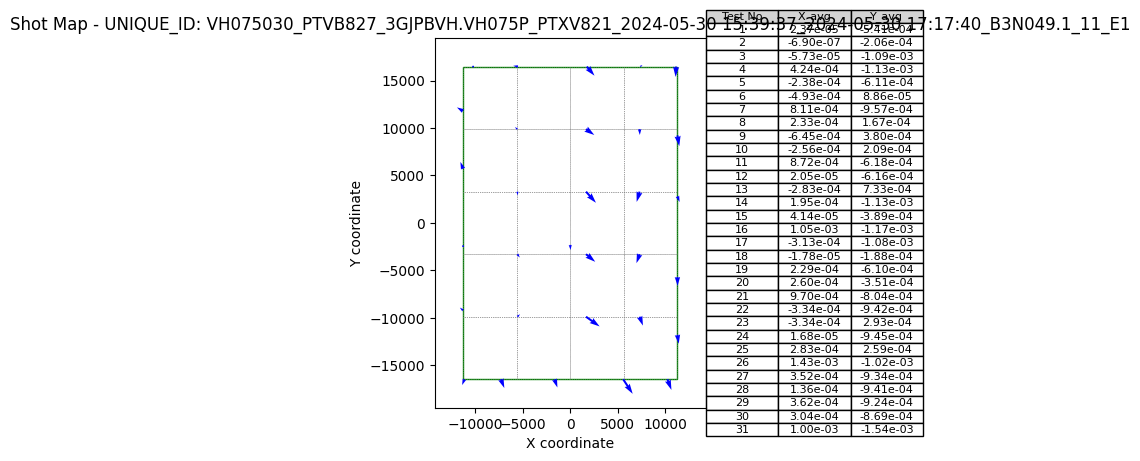

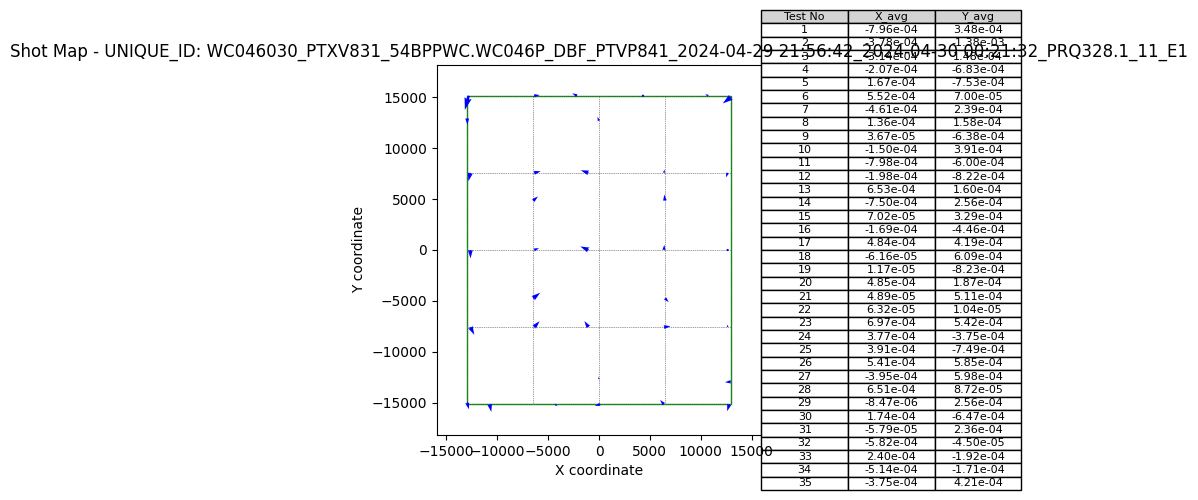

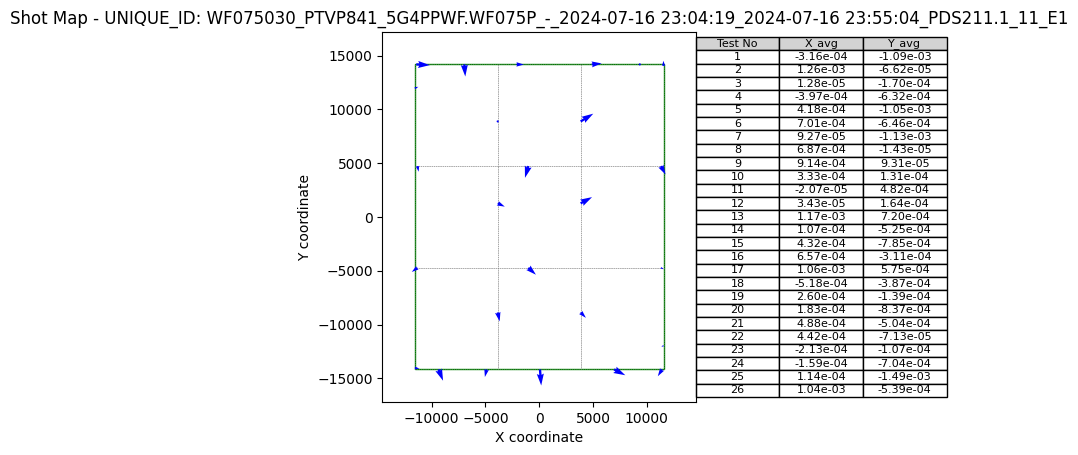

모든 데이터를 병합하여 하나의 CSV 파일로 저장했습니다: UNIQUE_ID_TEST_Xreg_Yreg_avg_combined.csv


In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import re

# 데이터 불러오기
file_path = 'RawData-1.csv'
df = pd.read_csv(file_path)

# UNIQUE_ID와 TEST, coordinate_X, coordinate_Y별 평균 계산
df_avg = df.groupby(['UNIQUE_ID', 'TEST', 'coordinate_X', 'coordinate_Y']).agg({'X_reg': 'mean', 'Y_reg': 'mean'}).reset_index()

# UNIQUE_ID 별로 shot map을 그리기
unique_ids = df_avg['UNIQUE_ID'].unique()

# 각 UNIQUE_ID에 대해 TEST 번호별 shot map 생성
for unique_id in unique_ids:
    df_subset = df[df['UNIQUE_ID'] == unique_id]
    df_avg_subset = df_avg[df_avg['UNIQUE_ID'] == unique_id]
    
    # 데이터 값들
    step_pitch_x = df_subset['STEP_PITCH_X'].iloc[0]
    step_pitch_y = df_subset['STEP_PITCH_Y'].iloc[0]
    chip_x_num = int(df_subset['CHIP_X_NUM'].iloc[0])
    chip_y_num = int(df_subset['CHIP_Y_NUM'].iloc[0])

    # shot의 중심 좌표
    shot_center_x = 0
    shot_center_y = 0

    # shot의 모서리 좌표 계산
    shot_left = shot_center_x - step_pitch_x / 2
    shot_bottom = shot_center_y - step_pitch_y / 2

    # chip의 크기 계산
    chip_width = step_pitch_x / chip_x_num
    chip_height = step_pitch_y / chip_y_num

    # 그림 그리기
    fig, ax = plt.subplots()

    # shot 사각형 그리기
    shot_rect = patches.Rectangle((shot_left, shot_bottom), step_pitch_x, step_pitch_y,
                                  linewidth=1, edgecolor='green', facecolor='none')
    ax.add_patch(shot_rect)

    # chip 경계선 점선으로 추가
    for i in range(chip_x_num):
        for j in range(chip_y_num):
            chip_left = shot_left + i * chip_width
            chip_bottom = shot_bottom + j * chip_height
            chip_rect = patches.Rectangle((chip_left, chip_bottom), chip_width, chip_height,
                                          linewidth=0.5, edgecolor='grey', linestyle='dotted', facecolor='none')
            ax.add_patch(chip_rect)

    # TEST 번호별로 평균 overlay 벡터 표시 (coordinate_X, coordinate_Y 위치에 맞춤)
    ax.quiver(df_avg_subset['coordinate_X'], df_avg_subset['coordinate_Y'], 
              df_avg_subset['X_reg'], df_avg_subset['Y_reg'], 
              angles='xy', scale_units='xy', scale=1e-6, color='blue')

    # TEST 번호별 X_avg, Y_avg 표 생성
    cell_text = []
    for _, row in df_avg_subset.iterrows():
        cell_text.append([int(row['TEST']), f"{row['X_reg']:.2e}", f"{row['Y_reg']:.2e}"])

    # 플롯 옆에 표 추가
    table = plt.table(cellText=cell_text, colLabels=["Test No", "X_avg", "Y_avg"], 
                      loc='right', cellLoc='center', colColours=["lightgrey"]*3)
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(0.8, 0.8)  # 표 크기 조절

    # 그래프 설정
    ax.set_xlim(shot_left - 3000, shot_left + step_pitch_x + 3000)
    ax.set_ylim(shot_bottom - 3000, shot_bottom + step_pitch_y + 3000)
    ax.set_aspect('equal')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title(f'Shot Map - UNIQUE_ID: {unique_id}')

    # 플롯 보여주기
    plt.show()

# 모든 UNIQUE_ID의 데이터를 하나의 CSV 파일로 저장
output_path = 'UNIQUE_ID_TEST_Xreg_Yreg_avg_combined.csv'
df_avg[['UNIQUE_ID', 'TEST', 'X_reg', 'Y_reg']].to_csv(output_path, index=False)
print(f"모든 데이터를 병합하여 하나의 CSV 파일로 저장했습니다: {output_path}")

